In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qnl_analysis import SimTools as ST
from qnl_analysis.SimTools import bit_to_trit, rot_x, rot_y, trit_z
from qnl_projects.BHDecoder import qutrit_utils as qutils

from importlib import reload
from functools import reduce

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def Hadamard_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X90'],
    ['Z{:.5f}'.format(-109.471*alpha)],
    ['EFZ{:.5f}'.format(54.7355*alpha)],
    ['X-90'],
    ['Z{:.5f}'.format(180*alpha)],
    ['EFZ{:.5f}'.format(-90*alpha)],
    ['EFY90']]
    
    return qutils.resulting_unitary(Hadamard_pulse_sequence)

def HadamardStar_to_identity(alpha):
    """ returns a single-qutrit unitary matrix which
    smoothly interpolates between the Hadamard gate and the identity gate
    When alpha is unity, it is the Hadamard
    When alpha is zero, it is the identity
    """
    
    Hadamard_pulse_sequence = [['EFY-90'],
    ['X-90'],
    ['Z{:.5f}'.format(109.471*alpha)],
    ['EFZ{:.5f}'.format(-54.7355*alpha)],
    ['X90'],
    ['Z{:.5f}'.format(-180*alpha)],
    ['EFZ{:.5f}'.format(90*alpha)],
    ['EFY90']]
    
    return qutils.resulting_unitary(Hadamard_pulse_sequence)

def Scrambler_to_identity(alpha):
    
    alpha_Had = Hadamard_to_identity(alpha)
    alpha_Had_dag = np.conj(alpha_Had).T
    
    alpha_Had_2q = np.kron(alpha_Had, alpha_Had)
    alpha_Had_dag_2q = np.kron(alpha_Had_dag, alpha_Had_dag)

    gates = [alpha_Had_dag_2q, ST.qt_cmin_p1, alpha_Had_2q, ST.qt_csum_p1]
    
    return reduce(np.dot, gates)

In [3]:
omega = np.exp(2*np.pi*1j/3)

X = np.matrix([[0,0,1],[1,0,0],[0,1,0]])
Z = np.matrix(np.diag([1, omega, omega*omega]))
Y = X*Z
V = X*Z*Z

Qutrit_ops = [
    np.matrix(np.eye(3), dtype = 'complex'),
    Z, 
    X, 
    Y, 
    V, 
    Z*Z,
    X*X,
    Y*Y,
    V*V,
]

In [4]:
alpha_range = np.linspace(0,1,50)
unitaries = [Scrambler_to_identity(alpha) for alpha in alpha_range]
OTOCs = np.array([np.real(ST.OTOC(Scrambler_to_identity(alpha), Qutrit_ops)) for alpha in alpha_range])

Text(0,0.5,'OTOC')

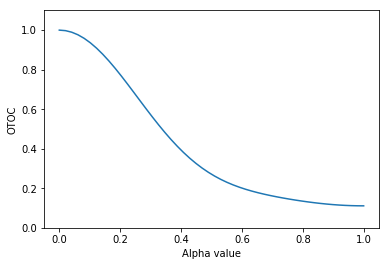

In [5]:
plt.plot(alpha_range, OTOCs)
plt.ylim(0,1.1)
plt.xlabel('Alpha value')
plt.ylabel('OTOC')

### Scrambler without the Hadamards at the beginning and end

Currently, the scrambler we're planning to use is the permutation.  But we can get away without doing the Hadamards on the beginning and end of the scrambler, just to win about five percent in total algorithm fidelity.  Here we confirm that doing this will still allow the algorithm to work.  

In [21]:
CSUM_phases = np.diag([1,1,1,1,np.exp(1j*4*np.pi/3), np.exp(1j*2*np.pi/3), 1, np.exp(1j*2*np.pi/3), np.exp(1j*4*np.pi/3)])

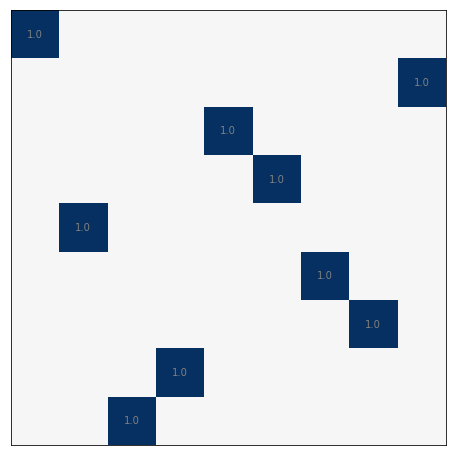

In [60]:
H0 = np.kron(np.eye(3), Hadamard_to_identity(1))
Hdag0 = np.conj(H0.T)

H1 = np.kron(Hadamard_to_identity(1), np.eye(3))
Hdag1 = np.conj(H1.T)

ST.plot_dm(reduce(np.dot, [H1, CSUM_phases, Hdag1, H0, H1, Hdag1, CSUM_phases, H1,Hdag1,Hdag0]));

In [87]:
def OtherScrambler_to_identity(alpha):
    CSUM_phases = np.diag([1,1,1,1,np.exp(1j*4*np.pi/3), np.exp(1j*2*np.pi/3), 1, np.exp(1j*2*np.pi/3), np.exp(1j*4*np.pi/3)])
    
    H0 = np.kron(np.eye(3), Hadamard_to_identity(1))
    Hdag0 = np.conj(H0.T)

    H1 = np.kron(Hadamard_to_identity(1), np.eye(3))
    Hdag1 = np.conj(H1.T)
    
    H0alpha = np.kron(np.eye(3), Hadamard_to_identity(alpha))
    Hdag0alpha = np.conj(H0.T)

    H1alpha = np.kron(Hadamard_to_identity(alpha), np.eye(3))
    Hdag1alpha = np.conj(H1.T)

    return np.matrix(reduce(np.dot, [CSUM_phases, Hdag1, H0alpha, H1alpha, Hdag1, CSUM_phases]))

In [88]:
alpha_range = np.linspace(0,1,50)
unitaries = [OtherScrambler_to_identity(alpha) for alpha in alpha_range]
OTOCs = np.array([np.real(ST.OTOC(OtherScrambler_to_identity(alpha), Qutrit_ops)) for alpha in alpha_range])

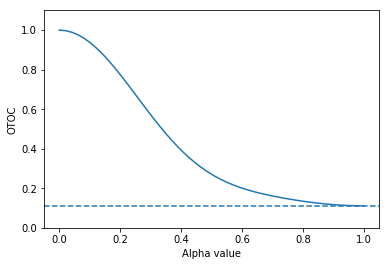

In [89]:
plt.plot(alpha_range, OTOCs)
plt.ylim(0,1.1)
plt.xlabel('Alpha value')
plt.ylabel('OTOC')
plt.axhline(1./9, ls = '--')

In [90]:
Hdag1q = np.conj(Hadamard_to_identity(1).T)

In [91]:
np.round(reduce(np.dot, [Hdag1q, Hdag1q]),5)

array([[ 1.+0.j,  0.-0.j, -0.-0.j],
       [-0.-0.j,  0.+0.j,  1.+0.j],
       [ 0.-0.j,  1.+0.j, -0.+0.j]])